In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored
from sksurv.util import Surv
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv


# --------------------------
# LOAD YOUR DATA (split 1)
# --------------------------
df = pd.read_csv("D:/Final_Year_Project/NHANES_FPCA_processed.csv")

In [2]:
# 1. Define all feature columns
features = ['Age', 'Race', 'BMI', 'sex', 'Mobility', 'diabetes.y',
            'poverty_level', 'Asthma', 'Arthritis', 'heart_failure',
            'coronary_heart_disease', 'angina', 'stroke', 'thyroid', 'bronchitis',
            'cancer', 'act_mean']

continuous_cols = ['Age', 'BMI', 'poverty_level', 'act_mean']

categorical_cols = ["Race", "sex", "Mobility", "diabetes.y", "Asthma", "Arthritis",
                    "heart_failure", "coronary_heart_disease", "angina", "stroke",
                    "thyroid", "bronchitis", "cancer"]

# 2. Split df into train and test once (based on raw df)
df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df["mortstat"], random_state=45
)

# Prepare survival objects
y_train = Surv.from_dataframe("mortstat", "time_mort", df_train)
y_test = Surv.from_dataframe("mortstat", "time_mort", df_test)

# Preprocessing pipeline (standardization + encoding)
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit on train
X_train_cont = scaler.fit_transform(df_train[continuous_cols])
X_test_cont = scaler.transform(df_test[continuous_cols])

X_train_cat = encoder.fit_transform(df_train[categorical_cols])
X_test_cat = encoder.transform(df_test[categorical_cols])

# Combine
X_train = pd.DataFrame(np.hstack([X_train_cont, X_train_cat]),
                       columns=continuous_cols + list(encoder.get_feature_names_out(categorical_cols)))
X_test = pd.DataFrame(np.hstack([X_test_cont, X_test_cat]),
                      columns=continuous_cols + list(encoder.get_feature_names_out(categorical_cols)))

In [3]:
# --------------------------
# CoxPH Fit
# --------------------------

coxPH = CoxPHSurvivalAnalysis()
coxPH.fit(X_train, y_train)

# Use predict on X_test (not a single sample!)
risk_scores_coxPH = coxPH.predict(X_train)

In [4]:
cindex_cph = coxPH.score(X_test, y_test)
print(cindex_cph)

0.7620554050511229


In [5]:
# --------------------------
# RSF Fit
# --------------------------

# 5. Fit the Random Survival Forest model
rsf = RandomSurvivalForest(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features=3,
    n_jobs=-1,
    oob_score=True,
    random_state=45
)
rsf.fit(X_train, y_train)

# Use predict on X_test (not a single sample!)
risk_scores_rsf = rsf.predict(X_train)

In [6]:
cindex_rsf = rsf.score(X_test, y_test)
print(cindex_rsf)

0.7831862273879228


In [7]:
# --------------------------
# GBSM Fit
# --------------------------

# Create survival model with best hyperparameters
gbsm = GradientBoostingSurvivalAnalysis(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=1,
    random_state=45
)

gbsm.fit(X_train, y_train)



GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=1,
                                 n_estimators=1000, random_state=45)

In [8]:
# Use predict on X_test (not a single sample!)
risk_scores_gbsm = gbsm.predict(X_train)

In [9]:
cindex_gbsm = gbsm.score(X_test, y_test)
print(cindex_gbsm)

0.7753124180721839


In [10]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reuse already preprocessed X_train and X_test above
x_train_tensor = torch.tensor(X_train.values.astype('float32')).to(device)
x_test_tensor = torch.tensor(X_test.values.astype('float32')).to(device)

# Define target as PyTorch tensors
def get_target_tensor(df):
    durations = torch.tensor(df["time_mort"].values, dtype=torch.float32).to(device)
    events = torch.tensor(df["mortstat"].values, dtype=torch.float32).to(device)
    return durations, events

y_train_tensor = get_target_tensor(df_train)
y_test_tensor = get_target_tensor(df_test)
durations_test, events_test = get_target_tensor(df_train)
val = (x_test_tensor, y_test_tensor)

# For evaluation later
durations_np = durations_test.cpu().numpy()
events_np = events_test.cpu().numpy()

In [11]:
in_features = x_train_tensor.shape[1]
num_nodes = [256,256]
out_features = 1
batch_norm = True
dropout = 0.7
output_bias = False

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
net_tuned = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias).to(device)

model_tuned = CoxPH(net_tuned, tt.optim.Adam)

batch_size = 64
lrfinder_tuned = model_tuned.lr_finder(x_train_tensor, y_train_tensor, batch_size, tolerance=10)

best_lr = lrfinder_tuned.get_best_lr()
model_tuned.optimizer.set_lr(best_lr)

epochs = 128
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

C:\Users\gh22s\AppData\Local\Programs\Python\Python310\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torc

In [12]:
%%time
log = model_tuned.fit(x_train_tensor, y_train_tensor, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.9896,	val_loss: 3.4289
1:	[0s / 1s],		train_loss: 3.6734,	val_loss: 3.4281
2:	[0s / 1s],		train_loss: 3.5745,	val_loss: 3.3709
3:	[0s / 2s],		train_loss: 3.5765,	val_loss: 3.4038
4:	[0s / 2s],		train_loss: 3.5616,	val_loss: 3.3851
5:	[0s / 3s],		train_loss: 3.5542,	val_loss: 3.3644
6:	[0s / 3s],		train_loss: 3.4721,	val_loss: 3.3537
7:	[0s / 4s],		train_loss: 3.4631,	val_loss: 3.3410
8:	[0s / 5s],		train_loss: 3.5114,	val_loss: 3.3947
9:	[0s / 5s],		train_loss: 3.4746,	val_loss: 3.3463
10:	[0s / 6s],		train_loss: 3.4802,	val_loss: 3.3728
11:	[0s / 6s],		train_loss: 3.4111,	val_loss: 3.3614
12:	[0s / 7s],		train_loss: 3.5585,	val_loss: 3.3980
13:	[0s / 7s],		train_loss: 3.4614,	val_loss: 3.3727
14:	[0s / 8s],		train_loss: 3.4575,	val_loss: 3.3308
15:	[0s / 8s],		train_loss: 3.4656,	val_loss: 3.3458
16:	[0s / 9s],		train_loss: 3.4634,	val_loss: 3.3447
17:	[0s / 9s],		train_loss: 3.3932,	val_loss: 3.3169
18:	[0s / 10s],		train_loss: 3.3813,	val_loss: 3.3631
19

In [13]:
_ = model_tuned.compute_baseline_hazards()
surv_tuned = model_tuned.predict_surv_df(x_train_tensor)
ev_tuned = EvalSurv(surv_tuned, durations_np, events_np, censor_surv='km')
ev_tuned.concordance_td()

0.8119543828984124

In [14]:
n_times = len(surv_tuned.index)

time_points = np.array([0.5,1,2,3,4,5,6,7,8,9])  # Match your time unit
auc_scores = []

for t in time_points:
    # Find closest time index in survival prediction
    closest_time_idx = np.argmin(np.abs(surv_tuned.index - t))
    
    # Get survival probabilities at time t
    surv_t = surv_tuned.iloc[closest_time_idx].values  # shape: (n_samples,)
    
    # Compute risk score = 1 - survival prob
    risk_score_deepsurv = 1 - surv_t
    
    # Binary event status: who had the event before or at time t
    event_at_t = (durations_np <= t) & (events_np == 1)
    
    # Censoring filter: exclude patients who are censored before t
    valid = (durations_np >= t) | ((durations_np <= t) & (events_np == 1))
    
    if np.sum(event_at_t[valid]) > 0:  # ensure at least one event
        auc_t = roc_auc_score(event_at_t[valid], risk_score_deepsurv[valid])
        auc_scores.append(auc_t)
        print(f"t = {t:.1f}, AUC = {auc_t:.3f}")
    else:
        auc_scores.append(np.nan)
        print(f"t = {t:.1f}, AUC = NaN (no events)")

mean_auc = np.nanmean(auc_scores)

t = 0.5, AUC = 0.790
t = 1.0, AUC = 0.841
t = 2.0, AUC = 0.824
t = 3.0, AUC = 0.818
t = 4.0, AUC = 0.827
t = 5.0, AUC = 0.836
t = 6.0, AUC = 0.838
t = 7.0, AUC = 0.839
t = 8.0, AUC = 0.846
t = 9.0, AUC = 0.916


In [15]:
coxPH_auc, coxPH_mean_auc = cumulative_dynamic_auc(
    y_train,
    y_train,
    risk_scores_coxPH,
    time_points
)

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train,
    y_train,
    risk_scores_rsf,
    time_points
)

gbsm_auc, gbsm_mean_auc = cumulative_dynamic_auc(
    y_train,
    y_train,
    risk_scores_gbsm,
    time_points
)

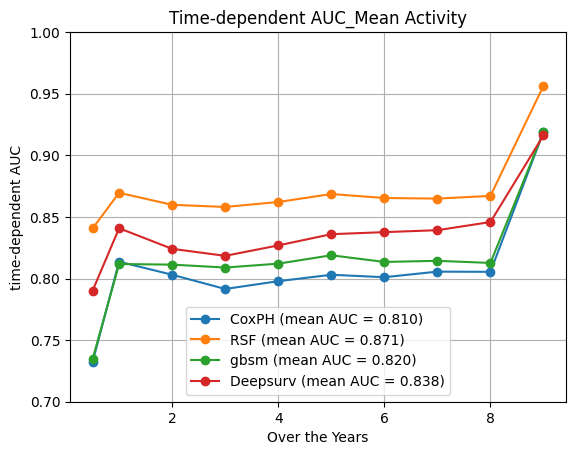

In [16]:
plt.plot(time_points, coxPH_auc, "o-", label=f"CoxPH (mean AUC = {coxPH_mean_auc:.3f})")
plt.plot(time_points, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.plot(time_points, gbsm_auc, "o-", label=f"gbsm (mean AUC = {gbsm_mean_auc:.3f})")
plt.plot(time_points, auc_scores, "o-", label=f"Deepsurv (mean AUC = {mean_auc:.3f})")

plt.xlabel("Over the Years")
plt.ylabel("time-dependent AUC")
plt.title("Time-dependent AUC_Mean Activity")
plt.legend(loc="lower center")

# Set custom Y-axis ticks
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

plt.grid(True)